# Gradient Boosting
## 1. Load packages

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, loguniform, randint

In [2]:
#def MAPE 
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
#define evaluation function 
def evaluation(y_true, y_pred):
    print("RMSE:", np.sqrt(mean_squared_error(y_pred, y_true)))
    print("MAPE:", mean_absolute_percentage_error(y_true, y_pred))

In [4]:
def plot_prediction(y_pred, y_test, xlabel, ylabel, title, png):
    plt.figure(0, figsize=(12,5))
    plt.plot(y_pred, '--', c='r', label='pred.', lw=2)
    plt.plot(y_test.values, c='black', label='actual', lw=2)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title, fontsize=17)
    plt.grid(which = 'both')
    plt.legend(fontsize=13)
    plt.savefig(png)
    plt.show()

## 2. Prepare data 

In [5]:
#load data
df = pd.read_csv("C:/Users/julie/supervised_project/df_PS2021.csv", index_col='Unnamed: 0')

#define X and y 
X = df[[
    'sim_wthr_fcst', 
    'sim_wthr_fcst2', 
    'weekday', 
    'hour', 
    'season', 
    'year',
    'load_lag24',
    'impFR_lag24',
    'impNL_lag24',
    'impPL_lag24',
    'impAT_lag24',
    'impCZ_lag24'
       ]]

y = df['load']

data_dmatrix = xgb.DMatrix(data=X,label=y)

#split the dataframe betweenn train and test 
X_train = X.iloc[:round(len(df)*0.75)]
y_train = y.iloc[:round(len(df)*0.75)]
X_test = X.iloc[round(len(df)*0.75):]
y_test = y.iloc[round(len(df)*0.75):]

## 3. Hyperparameter tuning

In [6]:
def report(results, n_top=3):
    '''https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
    '''
    # Utility function to report best scores
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


xgb_model = xgb.XGBRegressor()

param_search = {
    'max_depth': randint(5, 20),
    'min_child_weight': uniform(1.5, 1),
    'learning_rate': loguniform(1e-4, 1e0),
    'gamma': uniform(5, 5)
}

tscv = TimeSeriesSplit(n_splits=10)

rsearch = RandomizedSearchCV(
    estimator=xgb_model,
    cv=tscv,
    param_distributions=param_search,
    verbose=True,
    n_jobs=-1
).fit(X_train, y_train)

report(rsearch.cv_results_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.1min finished


Model with rank: 1
Mean validation score: 0.912 (std: 0.059)
Parameters: {'gamma': 6.030906111679343, 'learning_rate': 0.1176772737567674, 'max_depth': 13, 'min_child_weight': 2.0683566542364606}

Model with rank: 2
Mean validation score: 0.903 (std: 0.056)
Parameters: {'gamma': 5.6838895076509, 'learning_rate': 0.2739801693742319, 'max_depth': 13, 'min_child_weight': 1.8899637942993115}

Model with rank: 3
Mean validation score: 0.892 (std: 0.058)
Parameters: {'gamma': 5.393263158589761, 'learning_rate': 0.5044617704490781, 'max_depth': 7, 'min_child_weight': 1.5949350266101392}



## 4. Estimation

In [11]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          gamma = 5.393263158589761, 
                          learning_rate = 0.5044617704490781,
                          max_depth = 7, 
                          min_child_weight=  1.5949350266101392)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

RMSE_xgb = np.sqrt(mean_squared_error(y_test, preds))

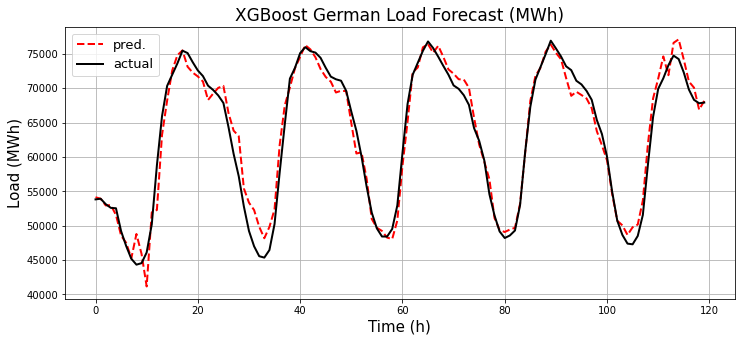

RMSE: 3447.272140750645
MAPE: 3.4875566581584394


In [15]:
plot_prediction(preds[:120], y_test[:120], 'Time (h)', 'Load (MWh)', 'XGBoost German Load Forecast (MWh)', "XGB_load_forecast.png")
evaluation(y_test, preds)

## 5. Evaluation

In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print("Root mean squared error is equal to:",RMSE_xgb, "MWh")
print("Mean absolute percentage error is equal to:", mean_absolute_percentage_error(y_test, preds))

Root mean squared error is equal to: 3447.272140750645 MWh
Mean absolute percentage error is equal to: 3.4875566581584394


## 6.Features importances

Text(0, 0.5, 'Feature Importance')

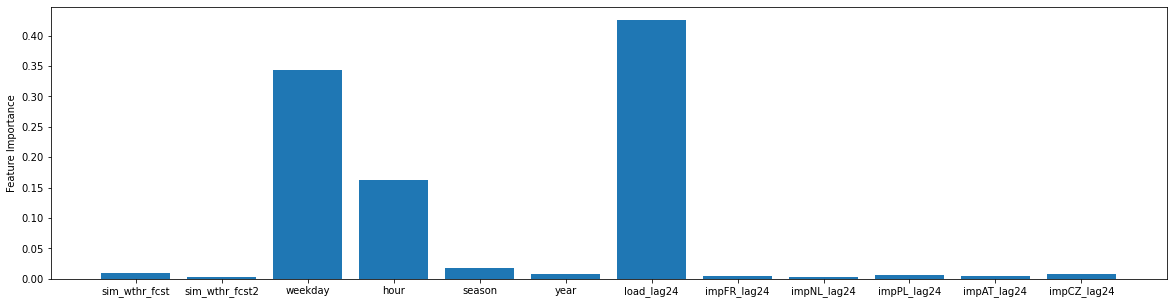

In [14]:
features_importances = xg_reg.feature_importances_

plt.figure(figsize=(20,5))
plt.bar(X.columns.to_list(),features_importances)
plt.ylabel("Feature Importance")